### Relevant libraries

In [1]:
push!(LOAD_PATH, "../src/")
using PyPlot, Logging
Logging.configure(level=DEBUG, filename="orcal_linear.log")

Logger(root,DEBUG,IOStream(<file orcal_linear.log>),root)

In [2]:
if length(workers()) > 1
    rmprocs(workers())
end
addprocs(11)
@everywhere push!(LOAD_PATH, "../src/")
@everywhere using GP, Optim

### Simulated transition between the small M and large M regimes

In [3]:
# parameters
Δ, ntrial, res = 0.5, 10, 128 # resolution to sample the true tuning curvers at
ker = Kernel(Δ)
# noise std with signal fixed at 1
σns = Float64[sqrt(10), 1, sqrt(0.1)]
# number of nueonrs in the population
Ms = round(Int64, logspace(log10(2), log10(1000), 10));

In [4]:
# preallocation of the shared array
err = SharedArray(Float64, length(σns), length(Ms), ntrial)

for (ixσn, σn) in enumerate(σns)
    for (ixM, M) in enumerate(Ms)
        debug("ixσn: $ixσn, ixM: $ixM")        
        for ixtrial in 1:ntrial
            # true tuning curves
            θs, tcs = tc(res, M, ker)
            # test responses for error calculation
            r = tcs + randn(res, M) * σn
            # best output weights for decoding cosine using true tuning curves
            w = inv(tcs' * tcs / res + σn^2 * eye(M)) * tcs' * cos(θs) / res
            # error of decoded cosine functions with noisy response
            err[ixσn, ixM, ixtrial] = sum((r * w - cos(θs)).^2 / res)
        end
    end
end

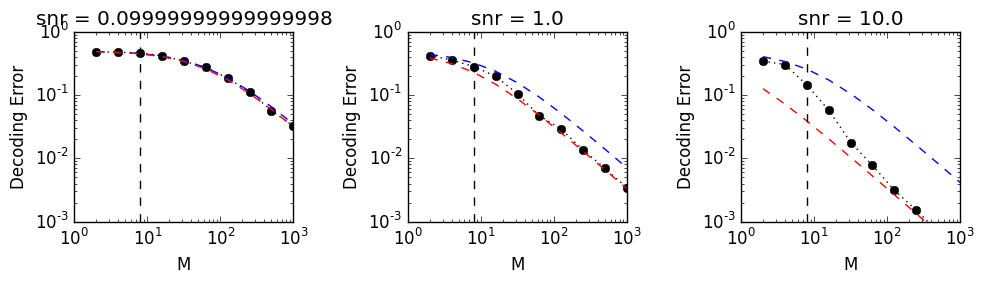

In [5]:
# plot the results
figure(figsize=(10, 3))

for (ixσn, σn) in enumerate(σns)
    subplot(1, 3, ixσn)
    PyPlot.locator_params(nbins=3)
    
    # plot data
    plot(Ms, vec(mean(err[ixσn, :, :], 3)), "ko:")
    
    # theoretical decoding performances in the two limits
    err_subopt = Float64[GP.e_cos_subopt(M, σn, GP.Kernel(Δ)) for M in Ms]
    err_large = Float64[GP.e_cos_large(M, σn, GP.Kernel(Δ)) for M in Ms]
    plot(Ms, err_subopt, "b--")
    plot(Ms, err_large, "r--")
    # predicted transition location
    PyPlot.axvline(4 / Δ, linestyle="--", color="k")
    
    xscale("log"); yscale("log")
    xlabel("M"); ylabel("Decoding Error"); title("snr = $(1/σn^2)")
    ylim([1e-3, 1])
end
tight_layout()

### Simulate the transitions between the small and large population regimes

In [8]:
# simulation parameters
Δ, ntrial, res = 0.1, 10, 128
ker = GP.Kernel(Δ)
σns = logspace(0.5, -1, 20)
Ms = round(Int64, logspace(log10(2), log10(1000), 20));

In [9]:
# preallocate arrays simulated results and upper/lower bounds
err = SharedArray(Float64, length(σns), length(Ms), ntrial)
upper, lower = zeros(length(σns), length(Ms)), zeros(length(σns), length(Ms))

for (ixσn, σn) in enumerate(σns)
    for (ixM, M) in enumerate(Ms)
        debug("ixσn: $ixσn, ixM: $ixM")
        
        upper[ixσn, ixM] = GP.e_cos_subopt(M, σn, ker)
        lower[ixσn, ixM] = GP.e_cos_large(M, σn, ker)
        @sync @parallel for ixtrial in 1:ntrial
            # tuning curves
            θs, tcs = tc(res, M, ker)
            # responses
            r = tcs + randn(res, M) * σn
            # best output weights
            w = inv(tcs' * tcs / res + σn^2 * eye(M)) * tcs' * cos(θs) / res
            # compute decoding error
            err[ixσn, ixM, ixtrial] = sum((r * w - cos(θs)).^2 / res)
        end
    end
end

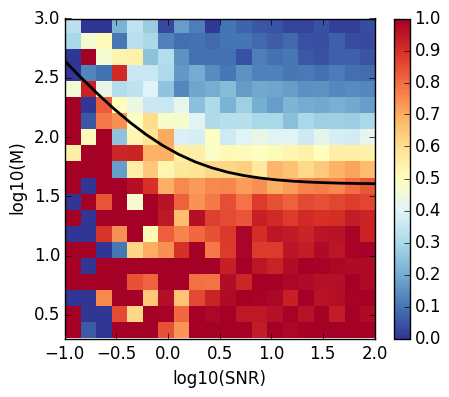

PyObject <matplotlib.colorbar.Colorbar object at 0x7f1ed599ea58>

In [12]:
figure(figsize=(5, 4))
# plot if the simulated response is closer to the small or the large M limits
extent = [extrema(-log10(σns.^2))..., extrema(log10(Ms))...]
err_mean = log10(squeeze(mean(err, 3), 3))
imshow((err_mean - log10(lower))' ./ (log10(upper) - log10(lower))', aspect="auto", vmin=0, vmax=1,
        interpolation="nearest", origin="lower", cmap="RdYlBu_r", extent=extent)
# plot the transition
Mp = 2 * coth(Δ/2) - tanh(Δ)
plot(-log10(σns.^2), log10(4 / Δ * (1 + σns.^2)), color="k", linewidth=2)

ylim([extrema(log10(Ms))...]); xlabel("log10(SNR)"); ylabel("log10(M)")
colorbar()